In [ ]:
# !pip install opencv-python
# !pip install --upgrade tensorflow
# !apt-get update
# !apt-get install -y libgl1-mesa-glx

In [ ]:
!pip install Pympler

ONLY FOR TPU - RUNTIME ENVR (ABOVE) -------------------------------------------------------------------------------

Add <b>Attention to the mask (while training) for better representation + train more + get some result

In [1]:
import os
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
import random
import cv2 
from IPython import display
import time 
import gc
from pympler import asizeof
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

#### Direct Retrieval
DATA --> (Mixed_Dataset, Mixed_label, Z_mean, Z_mean_reduced) <b> IMP: ONLY take images that have NON-ZERO masks </b> <br>
MODEL --> (Weights, Biases)

In [14]:
# parent_path = r"/kaggle/input/limited-data-3/Limited-Data"
parent_path = r"/kaggle/input/limited-data-medium/Limited-Data-Medium"

# fname = ['Mixed-Data.npy', 'Mixed-Label.npy', 'Mixed-Positive-Label.npy', 'Per-Index.npy', 'high-dim-LS.npy', '2D-LS.npy']
fname = ['Mixed-Data.npy', 'Mixed-Label.npy', 'Mixed-Positive-Label.npy']

mixed = np.load(os.path.join(parent_path, fname[0]))
mixed_label = np.load(os.path.join(parent_path, fname[1]))
mixed_positive_labels = np.load(os.path.join(parent_path, fname[2]))

# per_index = np.load(os.path.join(parent_path, fname[3]))
# z_mean = np.load(os.path.join(parent_path, fname[4]))
# z_mean_reduced = np.load(os.path.join(parent_path, fname[-1]))


''' ONLY selectig NON-ZERO masks'''

mixed = mixed[mixed_positive_labels == 1]
mixed_label = mixed_label[mixed_positive_labels == 1]


# z_mean = z_mean[mixed_positive_labels == 1]
# z_mean_reduced = z_mean_reduced[mixed_positive_labels == 1]

'''--------------------------------- '''

# print(mixed.shape, mixed_label.shape, mixed_positive_labels.shape, per_index.shape, z_mean.shape, z_mean_reduced.shape)
print(mixed.shape, mixed_label.shape)

del mixed_positive_labels
gc.collect()

(6828, 128, 128, 1) (6828,)


4613

In [15]:
def rough_mem_gb(arr):
    
    print(arr.dtype)
    size_in_bytes = asizeof.asizeof(arr)
    size_in_mb = (size_in_bytes / 1024) / 1024
    size_in_gb = ((size_in_bytes / 1024) / 1024) / 1024
    
    print(f"Size of the array: {size_in_mb} MB")
    print(f"Size of the array: {size_in_gb} GB")

test_arr = np.random.randint(0, 255,size = (50, 64, 64, 1))    
rough_mem_gb(test_arr)

del test_arr
gc.collect()

int64
Size of the array: 1.5626678466796875 MB
Size of the array: 0.0015260428190231323 GB


0

In [4]:
TRAIN_BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
VAL_BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation'
TEST_BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'

N_TIMES_BEFORE = 4
record_id = ['1704010292581573769', '1000660467359258186', '10038729395249389', '1002294268041839364']
record_id_list = os.listdir(TRAIN_BASE_DIR)
train_len = len(record_id_list)
print("TRAIN_LEN: ", train_len)

## Out of 16 ABI bands 2 visible, 4 near-IR and 10 IR --> We consider 8 IR (from the topospheric region)
## BANDS (8-16) REFER TO DIFFERENT CHANNELS OF INFRARED WAVELENGTHS (4 before frames, 3 after frames)

seed = random.randint(0, len(record_id_list) - 1)
print("Seed: ", seed)
seed = 6815

'''

11: Cloud-Top Phase Band , 8.4 Micron 
14: IR Longwave Window Band, 11.2 Micron
15: Dirty Longwave Window band, 12.3 Micron

'''

def FilesAccess(rname = '', BASE_DIR = '', data = True, seed = 0):
    if data:
        with open(os.path.join(BASE_DIR, rname, 'band_11.npy'), 'rb') as f: 
            band11 = np.load(f)
        with open(os.path.join(BASE_DIR, rname, 'band_14.npy'), 'rb') as f:
            band14 = np.load(f)
        with open(os.path.join(BASE_DIR, rname, 'band_15.npy'), 'rb') as f:
            band15 = np.load(f)
        
        if BASE_DIR.split('/')[-1] == 'test':
            human_pixel_mask = ''
        else:
            with open(os.path.join(BASE_DIR, rname, 'human_pixel_masks.npy'), 'rb') as f:
                human_pixel_mask = np.load(f)
        
        if BASE_DIR.split('/')[-1] == 'train':
            with open(os.path.join(BASE_DIR, rname, 'human_individual_masks.npy'), 'rb') as f:
                human_individual_mask = np.load(f)
        else:
            human_individual_mask = ''
            
        minn, maxx = min(np.ravel(band14)), max(np.ravel(band14))
            
        return band11, band14, band15, human_pixel_mask, human_individual_mask, minn, maxx
    
    else:
        with open(os.path.join(BASE_DIR, record_id_list[seed], 'band_11.npy'), 'rb') as f: 
                band11 = np.load(f)
        with open(os.path.join(BASE_DIR, record_id_list[seed], 'band_14.npy'), 'rb') as f:
            band14 = np.load(f)
        with open(os.path.join(BASE_DIR, record_id_list[seed], 'band_15.npy'), 'rb') as f:
            band15 = np.load(f)
        with open(os.path.join(BASE_DIR, record_id_list[seed], 'human_pixel_masks.npy'), 'rb') as f:
            human_pixel_mask = np.load(f)
        with open(os.path.join(BASE_DIR, record_id_list[seed], 'human_individual_masks.npy'), 'rb') as f:
            human_individual_mask = np.load(f)
            
        return band11, band14, band15, human_pixel_mask, human_individual_mask
    
band11, band14, band15, human_pixel_mask, human_individual_mask = FilesAccess(BASE_DIR = TRAIN_BASE_DIR, data=False, seed = seed)
minn, maxx = min(np.ravel(band14)), max(np.ravel(band14)) ## DTYPE: Float32
print("Range: ", minn,  '-' , maxx)

TRAIN_LEN:  20529
Seed:  2272
Range:  218.03659 - 315.7212


### Combine bands into a false color image
In order to view contrails in GOES, we use the "ash" color scheme. This color scheme was originally developed for viewing volcanic ash in the atmosphere but is also useful for viewing thin cirrus, including contrails. In this color scheme, contrails appear in the image as dark blue.

Note that we use a modified version of the ash color scheme here, developed by Kulik et al., which uses slightly different bands and bounds tuned for contrails.

References:
 - Ash Color Scheme (page 7): https://eumetrain.org/sites/default/files/2020-05/RGB_recipes.pdf

float32  ,  0.0 1.0


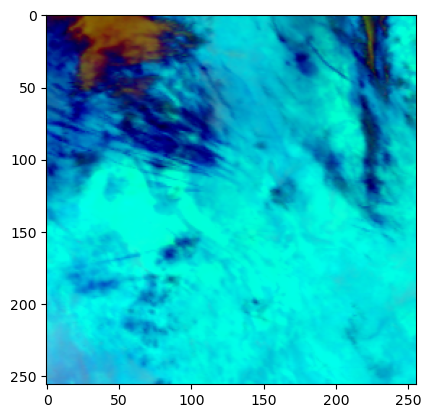

In [16]:
# _T11_BOUNDS = (243, 303)


_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def False_image_creation(band11, band14, band15, minn, maxx):
    def normalize_range(data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

## We normalize the the bands diff and band to create r, g, b channels out of infrared channels
    _T11_BOUNDS = (minn, maxx)
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    
    return false_color

false_color = False_image_creation(band11, band14, band15, minn, maxx)

img = false_color[..., N_TIMES_BEFORE]
print(img.dtype, ' , ',min(np.ravel(img)), max(np.ravel(img)))

plt.imshow(false_color[..., N_TIMES_BEFORE])
plt.show()

## Visualize data

Only 1 frame is actually labeled, so in as a sequential addition we have 4 before frames and 3 after frames

In [ ]:
test_img = false_color[..., N_TIMES_BEFORE] ## we select the 4th index along the last dim
print(img.shape)

gray_test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

print('Variation: ', set(np.ravel(human_pixel_mask)))

fig, ax = plt.subplots(1, 4, figsize=(18, 6))

ax[0].imshow(test_img, cmap = 'gray')
ax[0].set_title('False color image')

ax[1].imshow(gray_test_img, cmap = 'gray')
ax[1].set_title('False gray color image')

ax[2].imshow(human_pixel_mask, interpolation='none', cmap = 'gray')
ax[2].set_title('Ground truth contrail mask')

human_pixel_mask_inv = abs(1 - human_pixel_mask)
gray_test_img_masked = np.add(np.expand_dims(gray_test_img, axis = -1), human_pixel_mask_inv / 2)
gray_test_img_masked = gray_test_img_masked - np.min(gray_test_img_masked)
gray_test_img_masked /= np.max(gray_test_img_masked).astype('float32')

print(gray_test_img.shape)

ax[3].imshow(gray_test_img_masked, cmap='gray')
# ax[3].imshow(human_pixel_mask_inv, cmap='gray', alpha=.4, interpolation='none')
ax[3].set_title('Contrail mask on false color image');

print()

print('GRAY-IMG')
print(gray_test_img.dtype, ' , ',min(np.ravel(gray_test_img)), max(np.ravel(gray_test_img)))

print('GRAY-IMG-MASKED')
print(gray_test_img_masked.dtype, ' , ',min(np.ravel(gray_test_img_masked)), max(np.ravel(gray_test_img_masked)))

reduced_shape = (128, 128)

gray_test_img, gray_test_img_masked = cv2.resize(gray_test_img, reduced_shape), cv2.resize(gray_test_img_masked, reduced_shape)

In [ ]:
'''ONLY for false colored '''


test_img_masked = np.add(test_img, human_pixel_mask_inv)
test_img_masked = test_img_masked - np.min(test_img_masked)
test_img_masked /= np.max(test_img_masked).astype('float32')

reduced_shape = (128, 128)

test_img = cv2.resize(test_img, reduced_shape)
test_img_masked = cv2.resize(test_img_masked, reduced_shape)

print(test_img.shape, test_img_masked.shape)


fig, ax = plt.subplots(1, 2, figsize=(6, 6))

ax[0].imshow(test_img, cmap = 'gray')
ax[0].set_title('False color image')

ax[1].imshow(test_img_masked, cmap = 'gray')
ax[1].set_title('False color image (masked)')

plt.tight_layout(pad = 2)
plt.show()

In order for a <b> pixel </b> to be considered a contrail, it needs to be have approval of >50% human labels  

In [ ]:
# Individual human masks
n = human_individual_mask.shape[-1]
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(human_individual_mask[..., i], interpolation='none', cmap = 'gray')

### BASIC FOURIER FILTERING 

In [ ]:
def draw_cicle(shape,diameter):
    '''
    Input:
    shape    : tuple (height, width)
    diameter : scalar
    
    Output:
    np.array of shape  that says True within a circle with diamiter =  around center 
    '''
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    center = np.array(TF.shape)/2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diameter **2
    return(TF)


TFcircleIN   = draw_cicle(shape=img.shape[:2],diameter=5)
TFcircleOUT  = ~TFcircleIN

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(1,2,1)
im  = ax.imshow(TFcircleIN,cmap="gray")
# plt.colorbar(im)
ax  = fig.add_subplot(1,2,2)
im  = ax.imshow(TFcircleOUT,cmap="gray")
# plt.colorbar(im)
plt.show()

In [ ]:
def FFT(img):
    fourier_transform = np.fft.fft2(img)
    shifted_transform = np.fft.fftshift(fourier_transform)
    power_spectrum = np.abs(shifted_transform) ** 2
    return power_spectrum, shifted_transform

In [ ]:
cutoff_frequency_row = 2
cutoff_frequency_col = 2 #1, #2

cutoff_frequency_circle = 5

# img = noisy_test_imag/e

def driverFFT(gray_img, data=False):
    image = gray_img

    _,shifted_transform = FFT(image)
    true_power_spectrum = np.abs(shifted_transform) ** 2 

    rows, cols = image.shape
    crow, ccol = int(rows / 2), int(cols / 2)  # Center of the image

    ''' Target-Region '''

    rows, cols = image.shape
    trow, tcol = int(rows/2), int(cols/2)  # Center of the image
    # Create a mask of ones, except for the low-frequency region which will be set to zero
    mask = np.ones((rows, cols))
    mask[:, tcol - cutoff_frequency_col: tcol + cutoff_frequency_col] = 0
    mask[trow - cutoff_frequency_row: trow + cutoff_frequency_row, :] = 0
    mask =  abs(mask - 1)

    # '''''''

    circle_mask_high = ~draw_cicle(shape=img.shape[:2],diameter=cutoff_frequency_circle) ## HIGH-PASS FILTER
    circle_mask_low = draw_cicle(shape=img.shape[:2],diameter=cutoff_frequency_circle) ## LOW-PASS FILTER

    ''' ADDITIVE - MASK | RECT + CIRCLE'''
    new_mask = mask + circle_mask_low
    # new_mask =  abs(new_mask - 1)

    filtered_transform = shifted_transform * new_mask
    # filtered_transform = shifted_transform * mask

    power_spectrum_fil = np.abs(filtered_transform) ** 2
    
    shifted_filtered_transform = np.fft.ifftshift(filtered_transform)
    filtered_image_array = np.fft.ifft2(shifted_filtered_transform)
    filtered_image = np.abs(filtered_image_array)

    sub_filtered_image = (image - filtered_image)
    
    if data == False:
        
        print(min(np.ravel(image)), ' - ' , max(np.ravel(image)))
        print(image.dtype)

    
        fig, axs = plt.subplots(1, 6, figsize = (24, 24))

        axs[0].imshow(image, cmap='gray')
        axs[0].axis('off')

        axs[2].imshow(np.log10(power_spectrum_fil + 1), cmap='gray')
        axs[2].set_title("Power Spectrum (LowPass-filter)")


        axs[3].imshow(filtered_image, cmap='gray')
        axs[3].axis('off')

        axs[1].imshow(np.log10(true_power_spectrum + 1), cmap='gray')
        axs[1].set_title("Power Spectrum")
        # axs[3].axis('off')

        axs[4].imshow(sub_filtered_image, cmap='gray')
        axs[4].axis('off')

        axs[5].imshow(sub_filtered_image, cmap='gray')
        axs[5].imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
        axs[5].set_title('Contrail mask on Filterd Image')

        plt.show()

    return sub_filtered_image

fft_filtered_image = driverFFT(gray_img, data = False)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_flattened = (fft_filtered_image * 255).astype('uint8').flatten()

# Plot the histogram
plt.hist(image_flattened, bins=256, range=[0, 256], color='gray', alpha=0.7)
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Intensity Distribution')
plt.show()

#### Dataset Creation

In [ ]:
train_range = 2000 ## 5000 will take ~50 mins
val_range = 30
test_range = 2
data = True

shapes = (256, 256)

# print(train_images.shape, target_images.shape)


def DatasetPipeline(_range = 10, base_dir = ''):
    
    images = np.empty(shape = (_range, shapes[0], shapes[1], 1))
    target = np.empty(shape = (_range, shapes[0], shapes[1], 1))
    
    record_id_list = os.listdir(base_dir)
    for step, rname in enumerate(record_id_list[:_range]):
        
        band11, band14, band15, human_pixel_mask, _, minn, maxx = FilesAccess(rname, BASE_DIR = base_dir, data=data)
        false_color_img = False_image_creation(band11, band14, band15, minn, maxx)[..., N_TIMES_BEFORE]
        gray_img = cv2.cvtColor(false_color_img, cv2.COLOR_BGR2GRAY)
        human_pixel_mask_inv = abs(1 - human_pixel_mask)
        gray_img_masked = np.add(np.expand_dims(gray_img, axis = -1), human_pixel_mask_inv / 2)

#         print('#' + str(count), fft_filtered_image.shape, human_pixel_mask.shape)

        if base_dir.split('/')[-1] != 'test':
            images[step] = gray_img
            target[step] =  gray_img_masked
        else:
            images[step] = fft_filtered_image
    
    return images, target
     
ft = time.time()
train_images, target_images = DatasetPipeline(_range = train_range, base_dir = TRAIN_BASE_DIR)

val_images, val_targets = DatasetPipeline(_range = val_range, base_dir = VAL_BASE_DIR)

test_images, _ = DatasetPipeline(_range = test_range, base_dir = TEST_BASE_DIR)
lt = time.time()

print("Time-Taken: ", (lt - ft) / 60)

print(train_images.shape, target_images.shape, val_images.shape, val_targets.shape, test_images.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, target_images)).batch(2)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_targets)).batch(2)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

# train_dataset = tf.cast(train_dataset, dtype = tf.float32)

tf.print(train_dataset, val_dataset, test_dataset)

In [ ]:
import gc

del train_dataset, val_dataset, test_dataset
del train_images, target_images
gc.collect()

##### MIXED DATASET

In [ ]:
import time
import gc

reduced_shape = (128, 128, 1)
data = True

mask_inv_val = 0 

ft = time.time()
_range = 2000

mixed = np.empty(shape = (_range, reduced_shape[0], reduced_shape[1], reduced_shape[-1]), dtype = 'float32')
mixed_m = np.empty(shape = (_range, reduced_shape[0], reduced_shape[1], reduced_shape[-1]), dtype = 'float32')
mixed_label = np.zeros(shape = (_range,), dtype = 'float32')
mixed_m_label = np.ones(shape = (_range,), dtype = 'float32')
mixed_positive_labels = np.zeros(shape = (_range,), dtype = 'float32')

for step, rname in enumerate(record_id_list[:_range]):
    
    ''' THERE IS DUPLICACY FOR IMAGES HAVING NO-CONTRAILS '''
    
    band11, band14, band15, human_pixel_mask, _, minn, maxx = FilesAccess(rname, BASE_DIR = TRAIN_BASE_DIR, data=data)   
    false_color_img = False_image_creation(band11, band14, band15, minn, maxx)[..., N_TIMES_BEFORE]
    
    ''' FALSE-COLOR '''
#     false_color_img = cv2.resize(false_color_img, reduced_shape[:-1])
#     human_pixel_mask_inv = abs(1 - human_pixel_mask).astype('float32')
#     human_pixel_mask_inv = np.expand_dims(cv2.resize(human_pixel_mask_inv, reduced_shape[:-1]), axis=-1)
#     fsc_masked = np.add(false_color_img, human_pixel_mask_inv)
#     fsc_masked = fsc_masked - np.min(fsc_masked)
#     fsc_masked /= np.max(fsc_masked).astype('float32')
    
#     mixed[step] = false_color_img
#     if mask_inv_val in list(np.ravel(human_pixel_mask_inv)):
#         mixed_m[step] = fsc_masked
#     else:
#         mixed_m[step] = false_color_img
#         mixed_m_label[step] = 0
   
    ''' GRAY-SCLAE '''
    gray_img = np.expand_dims(cv2.resize(cv2.cvtColor(false_color_img, cv2.COLOR_BGR2GRAY), reduced_shape[:-1]), axis = -1)
    human_pixel_mask_inv = abs(1 - human_pixel_mask).astype('float32')
    human_pixel_mask_inv = np.expand_dims(cv2.resize(human_pixel_mask_inv, reduced_shape[:-1]), axis=-1)
    
#     gray_img_masked = human_pixel_mask_inv / 10

    gray_img_masked = np.add(gray_img, human_pixel_mask_inv / 1.5)
    gray_img_masked = gray_img_masked - np.min(gray_img_masked)
    gray_img_masked /= np.max(gray_img_masked).astype('float32')

    if mask_inv_val in list(np.ravel(human_pixel_mask_inv)):
        mixed_positive_labels[step] = 1

    
    ''' For Basic/Normal Labeling '''
    
    mixed[step] = gray_img
    mixed_m[step] = gray_img_masked
    
    ''' For Selective Labeling '''
    
#     mixed[step] = gray_img
#     if mask_inv_val in list(np.ravel(human_pixel_mask_inv)):
#         mixed_m[step] = gray_img_masked
#     else:
#         mixed_m[step] = gray_img
#         mixed_m_label[step] = 0
    
    
    ''' --------------------------------------------------------------------- '''
    
#     print(gray_img.shape, human_pixel_mask_inv.shape, gray_img_masked.shape)
#     print("GRAY_IN_R:", min(np.ravel(gray_img)), max(np.ravel(gray_img)))
#     print("GRAY_IN_R_M:", min(np.ravel(gray_img_masked)), max(np.ravel(gray_img_masked)))

#     fig, axs = plt.subplots(1,2, figsize = (6, 6))
#     axs[0].imshow(gray_img, cmap='gray')
#     axs[1].imshow(gray_img_masked, cmap='gray')
    
#     plt.show()
        
lt = time.time()

print("Time-Taken: ", (lt - ft) / 60)

mixed = np.concatenate((mixed, mixed_m), axis = 0)
mixed_label = np.concatenate((mixed_label, mixed_m_label), axis = 0)
mixed_positive_labels = np.concatenate((mixed_positive_labels, mixed_positive_labels), axis = 0)

print(mixed.shape, mixed_label.shape, mixed_positive_labels.shape, mixed_label[0])
print('No. of Positive-Mask Samples: ', len(mixed[mixed_positive_labels == 1]), '(Twice)')

del mixed_m, mixed_m_label
gc.collect()

Save relevant Data

In [ ]:
### use custom-permutation after loading
np.save("Mixed-Data.npy", mixed)
np.save("Mixed-Label.npy", mixed_label)
np.save("Mixed-Positive-Label.npy", mixed_positive_labels)

#### DATA-GENERATOR

In [ ]:
class Data_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_filenames, batch_size):
    self.fname = image_filenames[0]
    self.base_dir = image_filenames[-1]
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.fname) / float(self.batch_size))).astype(np.int32)
  
  
  def __getitem__(self, idx):
        
    data = True
    N_TIMES_BEFORE = 4
    ''' CHECK FOR PROPER SHAPES '''
    reduced_shape = (32, 32)
    
    batch_x = self.fname[idx * self.batch_size : (idx+1) * self.batch_size]
    mixed = np.empty(shape = (len(batch_x), reduced_shape[0], reduced_shape[1], 1), dtype = 'float32')
    mixed_m = np.empty(shape = (len(batch_x), reduced_shape[0], reduced_shape[1], 1), dtype = 'float32')
    
    for step, file_name in enumerate(batch_x):
        with open(os.path.join(self.base_dir, file_name, 'band_11.npy'), 'rb') as f: 
            band11 = np.load(f)
        with open(os.path.join(self.base_dir, file_name, 'band_14.npy'), 'rb') as f:
            band14 = np.load(f)
        with open(os.path.join(self.base_dir, file_name, 'band_15.npy'), 'rb') as f:
            band15 = np.load(f)
        
        band11, band14, band15, human_pixel_mask, _, minn, maxx = FilesAccess(file_name, BASE_DIR = TRAIN_BASE_DIR, data=data)
        false_color_img = False_image_creation(band11, band14, band15, minn, maxx)[..., N_TIMES_BEFORE]
        gray_img = np.expand_dims(cv2.resize(cv2.cvtColor(false_color_img, cv2.COLOR_BGR2GRAY), reduced_shape), axis = -1)
    #     fft_filtered_image = np.expand_dims(driverFFT(gray_img, data=data), axis =-1)
        human_pixel_mask_inv = (1 - human_pixel_mask).astype('float32')
        human_pixel_mask_inv = np.expand_dims(cv2.resize(human_pixel_mask_inv, reduced_shape), axis=-1)
        gray_img_masked = np.add(gray_img, human_pixel_mask_inv)
        gray_img_masked = gray_img_masked - np.min(gray_img_masked)
        gray_img_masked /= np.max(gray_img_masked).astype('float32')
    
        
        ## Just making a new permuatation (like duplication), no need to change formula for total batch no.s
        mixed[step] = gray_img
        mixed_m[step] = gray_img_masked
        
    return np.concatenate([mixed, mixed_m], axis=0)      
        

batch_size = 5

mixed_generator = Data_Generator([record_id_list, TRAIN_BASE_DIR], batch_size)

# my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size)

In [ ]:
ft = time.time()
sample_gen = mixed_generator[1]
lt = time.time()

print("Retrieval time for a single batch: ", (lt - ft)/60, ' mins') ## takes 9 mins to complete 1 epoch

print(sample_gen.shape, len(mixed_generator), min(np.ravel(sample_gen)), max(np.ravel(sample_gen)))

float32
Size of the array: 426.7501678466797 MB
Size of the array: 0.41674821078777313 GB
Memory-Usage:  None
Seed:  0
float32
R: 0.18482491 0.8014886


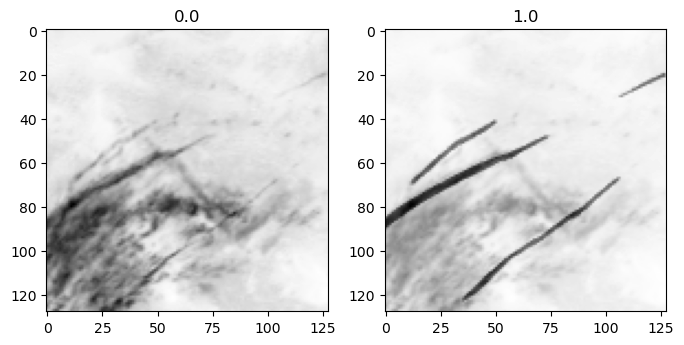

0.18482491 0.8014886
0.13400799 0.878211
0.11167547 0.7794194
0.12904729 0.7578526
0.17745367 0.9004864
0.0935664 0.90113914
0.058729477 0.76880604
0.39635321 0.786629
0.054352 0.9192902
0.09546492 0.8800446


In [17]:
print("Memory-Usage: ", rough_mem_gb(mixed))

# pos_len = len(mixed[mixed_positive_labels == 1])
pos_len = len(mixed)

seed = random.randint(0, pos_len - 1)
seed = 0
print("Seed: ", seed) #295
print(mixed[seed].dtype)
print("R:", min(np.ravel(mixed[seed])), max(np.ravel(mixed[seed])))

fig, axs = plt.subplots(1, 2, figsize = (8, 8))

# axs[0].imshow(mixed[mixed_positive_labels == 1][seed], cmap = 'gray')
# axs[0].set_title(mixed_label[mixed_positive_labels == 1][seed])
# axs[1].imshow(mixed[mixed_positive_labels == 1][seed + int(pos_len / 2)], cmap = 'gray')
# axs[1].set_title(mixed_label[mixed_positive_labels == 1][seed  + int(pos_len / 2)])

axs[0].imshow(mixed[seed], cmap = 'gray')
axs[0].set_title(mixed_label[seed])
axs[1].imshow(mixed[seed + int(pos_len / 2)], cmap = 'gray')
axs[1].set_title(mixed_label[seed  + int(pos_len / 2)])

plt.show()

for i in range(10):
    print(min(np.ravel(mixed[i])), max(np.ravel(mixed[i])))


Additional HMask

float32
0.20801449 - 3.0


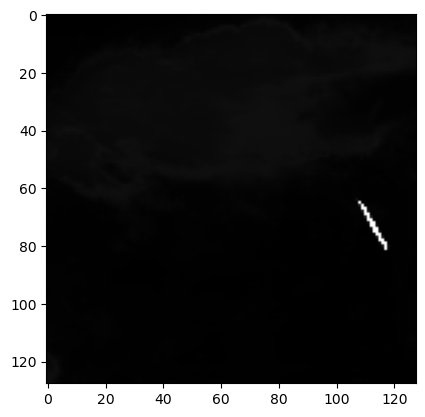

In [7]:
def human_mask_fn(mixed_data):
    
    mixed_norm = mixed_data[: len(mixed_data) // 2]
    mixed_mask_norm = mixed_data[len(mixed_data) // 2:]
    human_mask = np.tile(np.subtract(mixed_mask_norm, mixed_norm) * 1.5, reps = (2, 1, 1, 1))
    
    return abs(1 - human_mask)
    
human_mask = human_mask_fn(mixed)
human_mask = human_mask - np.min(human_mask)
human_mask /= np.max(human_mask).astype('float32')

# human_mask[human_mask < 0.4] = 0
human_mask[human_mask > 0.6] = 3


print(human_mask.dtype)
# print(min(np.ravel(human_mask)), '-', max(np.ravel(human_mask)))
seed = 69
temp_hmask = human_mask[seed]

print(min(np.ravel(temp_hmask)), '-', max(np.ravel(temp_hmask)))

plt.imshow(temp_hmask, cmap = 'gray')
plt.show()

In [18]:
''' If Per-Index NOT loaded | OR | IF perviously sampled only NON-ZERO masks'''
# per_index = np.random.permutation(np.arange(0, len(mixed_label)))

mixed = mixed[per_index]
mixed_label = mixed_label[per_index]
# mixed_positive_labels = mixed_positive_labels[per_index]
# human_mask = human_mask[per_index]

#### Autoencoder Reconstruction
We can perform Direct Frame-only mapping [NOW!] OR multiple before-after framer chaining <br>

Convolution --> De-Convolution

------------------------------------------------------------------------------

### !NOT Large

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2
t_shape = (32, 32, 1) 

encoder_inputs = tf.keras.layers.Input(shape=(t_shape[0], t_shape[1], 1))
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
p_encoder = tf.keras.models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
p_encoder.summary()

latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(np.prod(shape_before_flatten), activation="relu")(latent_inputs)
x = tf.keras.layers.Reshape((shape_before_flatten[0], shape_before_flatten[1], -1))(x)
x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
p_decoder = tf.keras.models.Model(latent_inputs, decoder_outputs, name="decoder")
p_decoder.summary()

### !Large

In [ ]:
class sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

t_shape = (64, 64, 1)
_input = tf.keras.layers.Input(shape=(t_shape[0], t_shape[1], 1))

# Encoder
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(_input)
# x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", strides = 2, padding="same")(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", strides = 2, padding="same")(x)
# x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation = 'relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim, activation = 'relu', name = 'z_mean')(x)
z_log_sig = tf.keras.layers.Dense(latent_dim, activation = 'relu', name = 'z_log_sig')(x)
## if you wrap it arounf lambda layer, you must implement the function using tf.keras.backend not tf
z = sampling()([z_mean, z_log_sig])
encoder = tf.keras.models.Model(inputs = _input, outputs = [z_mean, z_log_sig, z], name = 'encoder')
encoder.summary()

# Decoder
latent_inputs = tf.keras.layers.Input(shape = (latent_dim, ))

x = tf.keras.layers.Dense(np.prod(shape_before_flatten))(latent_inputs)
x = tf.keras.layers.Reshape((shape_before_flatten))(x)
x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=2, activation="sigmoid", padding="same")(x)
# x = tf.keras.layers.Resizing(28, 28)(x)

decoder = tf.keras.models.Model(inputs = latent_inputs, outputs = x, name = 'Decoder')
decoder.summary()

### !U-NET

In [19]:
class sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

NEED TO PROPERLY ADD MultiATTENTION | RIGHT NOW --> NO VALUE 

In [20]:
latent_dim = 412
# img_size = sample_gen[0].shape
img_size = mixed[0].shape

act = 'LeakyReLU'
    
def get_u_net_encoder():
    
    encoder_inputs = tf.keras.layers.Input(shape=img_size, name = 'Encoder_Input')
#     encoder_hmask = tf.keras.layers.Input(shape=img_size, name = 'Encoder_HMask_Input')
    
    x_inputs = tf.keras.layers.Conv2D(32, 3, strides=1, padding="same")(encoder_inputs)
#     x_hmask = tf.keras.layers.Conv2D(32, 3, strides=1, padding="same")(encoder_hmask)
    
    ### Sort of Cross and Pseudo-Self Attention
#     encoder_attn, attn_score = tf.keras.layers.Attention(score_mode = 'dot')(
#     [x_hmask, x_inputs], return_attention_scores = True)
#     x = tf.keras.layers.Concatenate(axis = -1)([x_hmask, encoder_attn])
    
#     x = tf.keras.layers.Dense(tf.keras.backend.int_shape(x)[-1], activation = act)(x)
    x = tf.keras.layers.BatchNormalization()(x_inputs)
    x = tf.keras.layers.Activation(act)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
        
    for step, filters in enumerate([128, 256, 256]):
        
        x = tf.keras.layers.Conv2D(filters, 3, strides = 2, padding="same")(x)
#         x_hmask = tf.keras.layers.Conv2D(filters, 3, strides = 2, padding="same")(x_hmask)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(act)(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        
#         if step > 0:
#             encoder_attn_inter = tf.keras.layers.Attention(score_mode = 'concat')(
#             [conv_out, x], return_attention_scores = False)
#             x = tf.keras.layers.Concatenate(axis = -1)([conv_out, encoder_attn_inter])
#             x = tf.keras.layers.LayerNormalization()(x)
#         else:
#             x = conv_out
          
#     x_attn = tf.keras.layers.Attention(score_mode = 'dot')(
#     [x, x_hmask], return_attention_scores = False)
#     x = tf.keras.layers.Concatenate(axis = -1)([x, x_attn])
#     x = tf.keras.layers.Dense(tf.keras.backend.int_shape(x)[-1], activation = act)(x)
    shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation = act)(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = sampling()([z_mean, z_log_var])
    u_net_encoder = tf.keras.models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    return u_net_encoder, shape_before_flatten

u_net_encoder, shape_before_flatten = get_u_net_encoder()
u_net_encoder.summary()

# print(shape_before_flatten)
    
def get_u_net_decoder(shape_before_flatten):
    
    latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name = 'Latent_Input')
    x = tf.keras.layers.Dense(np.prod(shape_before_flatten), activation = act)(latent_inputs)
    x = tf.keras.layers.Reshape((shape_before_flatten[0], shape_before_flatten[1], -1))(x)
        
    for filters in [256, 128, 32]:
        x = tf.keras.layers.Conv2DTranspose(filters, 3, strides = 2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(act)(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        
    x = tf.keras.layers.Conv2DTranspose(img_size[-1], 3, strides = 1, padding="same")(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    decoder_outputs = x
    u_net_decoder = tf.keras.models.Model(inputs = latent_inputs, outputs = decoder_outputs, name="decoder")
    return u_net_decoder

u_net_decoder = get_u_net_decoder(shape_before_flatten)
u_net_decoder.summary()

# Add a per-pixel classification layer
# outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

tf.keras.backend.clear_session()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['Encoder_Input[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

#### !ALTERNATE-VAE ARCH.

In [ ]:
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 412
LEARNING_RATE = 0.0005
EPOCHS = 50
BETA = 2000
LOAD_MODEL = False

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, metrics, optimizers, losses

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = tf.keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

alt_encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
alt_encoder.summary()

# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
alt_decoder = models.Model(decoder_input, decoder_output)
alt_decoder.summary()

------------------------------------------------------------------------------

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [28]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.w_recon = 3.0
        self.w_kl = 2.0
        self.total_loss_tracker = tf.keras.metrics.Mean(name = 'total_loss')
        self.recon_loss_tracker = tf.keras.metrics.Mean(name = 'recon_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name = 'kl_loss')
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker
        ]
    def train_step(self, data, training = True): ## write data
        
        _inp = data
        
        with tf.GradientTape() as tape:
            ## traces the operation for loss calc w.r.t train. parameters to perform automatic diff. later 
            z_mean, z_log_sig, z = self.encoder(_inp)
            output = self.decoder(z)
            ### BINARY CROSS. for binary prob. at every pixel of recon. image mismatch with binary target image. [NOT a spectrum of shades]
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(_inp, output), axis = (1, 2))
            )
            ## Approximating the Latent Distribution to multivariate standard normal distribution | continous
            kl_loss = - 0.5 * (1 * z_log_sig - tf.square(z_mean) - tf.exp(z_log_sig))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) # rank-2 tensor 
            total_loss = (self.w_recon * recon_loss) + (self.w_kl * kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        
        return {
            "Total_Loss": self.total_loss_tracker.result(),
            "Recons_Loss": self.recon_loss_tracker.result(),
            "KL_Loss": self.kl_loss_tracker.result(),
        }
    

#### Toy Dataset Creation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
mnist_path = '/kaggle/input/digit-recognizer/train.csv'

mnist_data = pd.read_csv(mnist_path).drop(['label'], axis=1)
mnist_label = pd.read_csv(mnist_path)['label']

mnist_data = mnist_data.to_numpy().reshape(42000, 28, 28, -1)
print(mnist_data.dtype, ' --' ,min(np.ravel(mnist_data[0])), max(np.ravel(mnist_data[0])))

# mnist_data = (mnist_data.astype('float32')) / 255
mnist_data = mnist_data.astype('uint8') / 255
print(mnist_data.dtype, ' --' ,min(np.ravel(mnist_data[0])), max(np.ravel(mnist_data[0])))

print(mnist_data.shape, mnist_label.shape)

plt.imshow(mnist_data[90], cmap = 'gray')
plt.title(str(mnist_label[90]))
plt.show()

#### TPU-TRAIN

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

#### MULTIPLE GPU - TRAIN

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Name:", gpu.name)
        print("Device type:", gpu.device_type)
else:
    print("No GPUs available")

In [29]:
# mul_gpu_strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])
# tpu_strategy = tf.distribute.TPUStrategy()

ft = time.time()

# with mul_gpu_strategy.scope():
# with tpu_strategy.scope():

# ---------------------------------------------------------------------------------------

# vae = VAE(encoder = p_encoder, decoder = p_decoder)
vae = VAE(encoder = u_net_encoder, decoder = u_net_decoder)    
# vae = VAE(encoder = alt_encoder, decoder = alt_decoder)
vae.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3))

es = tf.keras.callbacks.EarlyStopping(monitor = 'Total_Loss', patience = 3)

### It doesn't matter if it runs through the entire dataset, there is something fundamnetally wring in this process 
epochs = 30

values = vae.fit(
    mixed,
    batch_size = 64,
    epochs = epochs,
    shuffle = True,
    callbacks = [es],
#     validation_split = 0.2
)

# values = vae.fit(
#     mixed_generator,
#     steps_per_epoch = 332,
#     epochs = epochs,
#     shuffle = True,
#     callbacks = [es]
# )

#---------------------------------------------------------------------------

# optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
# pre_arch_vae.compile(optimizer=optimizer)

# values = pre_arch_vae.fit(
#     mixed,
#     batch_size = BATCH_SIZE,
#     epochs = EPOCHS,
#     callbacks = [es]
# )

lt = time.time()

print("Time taken for training: ", (lt - ft) / 60)

Epoch 1/30
107/107 [==============================] - 31s 157ms/step - Total_Loss: 31916.5436 - Recons_Loss: 10441.7525 - KL_Loss: 295.6456
Epoch 2/30
107/107 [==============================] - 16s 151ms/step - Total_Loss: 28467.6021 - Recons_Loss: 9308.2847 - KL_Loss: 271.3731
Epoch 3/30
107/107 [==============================] - 16s 151ms/step - Total_Loss: 28200.5373 - Recons_Loss: 9211.3598 - KL_Loss: 283.2295
Epoch 4/30
107/107 [==============================] - 16s 151ms/step - Total_Loss: 28214.3871 - Recons_Loss: 9211.7334 - KL_Loss: 289.5950
Epoch 5/30
107/107 [==============================] - 16s 151ms/step - Total_Loss: 28179.9205 - Recons_Loss: 9196.4484 - KL_Loss: 295.2860
Epoch 6/30
107/107 [==============================] - 16s 151ms/step - Total_Loss: 28031.0512 - Recons_Loss: 9145.8387 - KL_Loss: 296.7690
Epoch 7/30
107/107 [==============================] - 16s 152ms/step - Total_Loss: 28011.6181 - Recons_Loss: 9139.8274 - KL_Loss: 296.0677
Epoch 8/30
107/107 [======

['Total_Loss', 'Recons_Loss', 'KL_Loss']


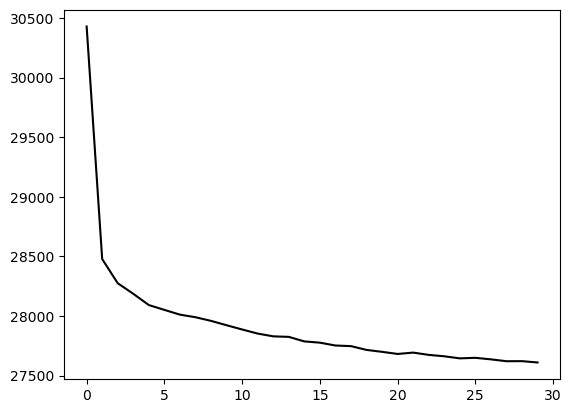

In [30]:
hist = values.history
keys = list(hist.keys()) 
print(keys)

plt.plot(np.arange(0, len(hist['Total_Loss']), 1), hist[keys[0]], 'k', label = 'Total Loss')
# plt.plot(np.arange(0, len(hist['Total_Loss']), 1), hist[keys[0]], 'k', label = 'Total Loss')
# plt.plot(np.arange(0, len(hist['Total_Loss']), 1), hist[keys[1]], 'r', marker = '.', label = 'Recons. Loss')
# plt.plot(np.arange(0, len(hist['Total_Loss']), 1), hist[keys[2]], 'b', label = 'KL Loss')
plt.show()

####  !LATENT - DISTRIB. | to see if the latent dist. is approximated to a multivariate standard normal  

63/63 [==============================] - 1s 10ms/step


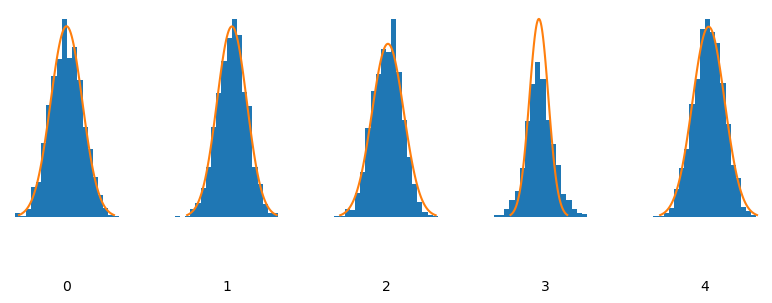

In [33]:
from scipy.stats import norm

seed_range = 2000

_, _, z_test = vae.encoder.predict(mixed[:seed_range])

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(5):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### MIXED SEGMENTATION

The more sparse/distant the points in the latent space, the more structural differences are amplified  --> The one having obv. structural diff are going to be easily dispersed/clustered, but the identical ones need more finer training procedures <br>

Structure of 6 & 9 are identical, Hence have mixed (--> identical) latent distrib.So sampled points for 6 will have mixture of 9's structure imbued 

<br>

0 --> Label for orginal gray-scaled image 
1 --> Label for masked gray-scaled image 

#### 2-D Latent-Space

214/214 [==============================] - 2s 10ms/step
(6828, 412)


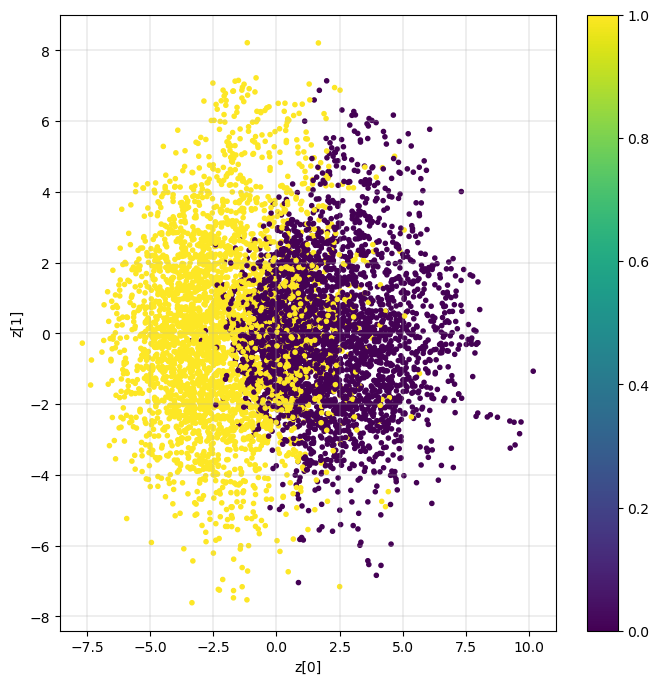

(6828, 2) (6828, 412)


In [47]:
from sklearn.decomposition import PCA

seed_range = 5000

def plot_latent_space(vae, mixed):
    ### large mooel hinders sep fot digits
    
    ''' For Attention Map'''
#     _, z_mean, _, _ = vae.encoder.predict([mixed[:seed_range], human_mask[:seed_range]]) # unshuff_mixed[mixed_positive_labels_unshuff == 1]) 
    
    ''' Normal '''
    z_mean, _, _ = vae.encoder.predict(mixed) # unshuff_mixed[mixed_positive_labels_unshuff == 1]) 
    
    print(z_mean.shape)
    n_components = 2  # Number of components to keep
    pca = PCA(n_components=n_components)
    pca.fit(z_mean)
    z_mean_reduced = pca.transform(z_mean)
    fig = plt.figure(figsize = (8,8))
#     plt.scatter(z_mean[:, 0], z_mean[:, 1], c = mixed_label)
    plt.scatter(z_mean_reduced[:, 0], z_mean_reduced[:, 1], marker = '.', c = mixed_label) #c = mixed_label[rev_per_index][mixed_positive_labels_unshuff == 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.grid(True, linewidth = 0.3)
    
    return z_mean_reduced, z_mean
    
# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255

z_mean_reduced, z_mean = plot_latent_space(vae, mixed)
plt.show()

print(z_mean_reduced.shape, z_mean.shape)

### Attention-Maps

Static-Seed 81
1/1 [==============================] - 0s 34ms/step
[[[0.00785456 0.0078163  0.00781317 ... 0.00780823 0.00780994 0.00778452]
  [0.00783147 0.0078194  0.00781519 ... 0.00780383 0.00780723 0.00777206]
  [0.00783053 0.00781949 0.00781534 ... 0.0078037  0.00780711 0.00777075]
  ...
  [0.00783049 0.00781891 0.00781509 ... 0.00780441 0.00780765 0.00777064]
  [0.00783064 0.00781896 0.00781513 ... 0.00780435 0.00780759 0.00777069]
  [0.00784481 0.00780694 0.00780313 ... 0.00782032 0.00782195 0.00785168]]

 [[0.00769519 0.007812   0.00781697 ... 0.00781732 0.00781523 0.00784903]
  [0.00778435 0.0078199  0.00781718 ... 0.00781927 0.00782057 0.00778168]
  [0.00778393 0.0078201  0.00781732 ... 0.00781904 0.00782035 0.00778091]
  ...
  [0.00779057 0.00781963 0.00781698 ... 0.00781887 0.00782017 0.00777773]
  [0.0077903  0.00781953 0.00781688 ... 0.00781893 0.00782023 0.00777931]
  [0.00783309 0.00781993 0.00781427 ... 0.007812   0.00781364 0.00774971]]

 [[0.00769627 0.00781402 0.00

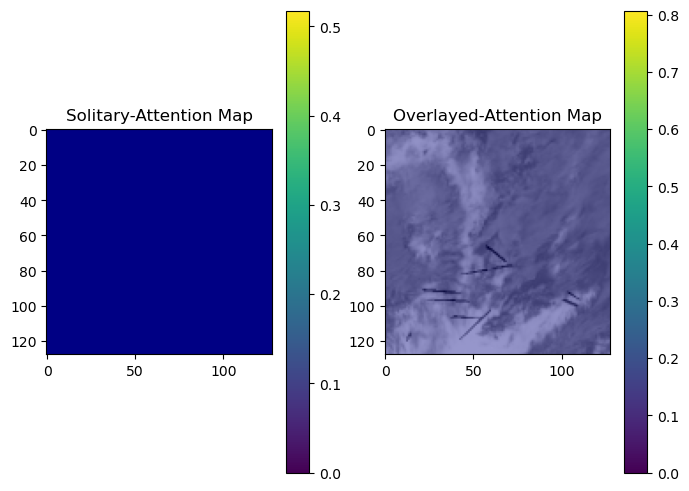

In [16]:
static_seed = random.randint(0, len(mixed[0]) - 1)
# static_seed = 87 #65, 87

print('Static-Seed', static_seed)

attn_map, _, _, _ = vae.encoder.predict([np.expand_dims(mixed[static_seed], axis = 0), 
                                         np.expand_dims(human_mask[static_seed], axis = 0)]) # unshuff_mixed[mixed_positive_labels_unshuff == 1]) 

print(attn_map[0])

print(attn_map.shape)
attn = np.mean(attn_map, axis = -1).squeeze()
print(attn[0])

attn = (attn * 255).astype('uint8')

# attn = (attn_map[:,:, :, 6].squeeze() * 255).astype('uint8') 

print(np.sum(np.ravel(attn)))
print(attn.shape, attn.dtype, type(attn))

attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
attn = np.float32(attn) / 255

print('Min-Max')
print(min(np.ravel(attn)), max(np.ravel(attn)))

temp_img = cv2.resize(mixed[static_seed], (attn.shape[0], attn.shape[1]))
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

vis = 0.6 * temp_img + 0.4 * attn

fig, axs = plt.subplots(1, 2, figsize = (8, 6))

im1 = axs[0].imshow(attn)
fig.colorbar(im1, ax=axs[0])
axs[0].set_title("Solitary-Attention Map")
    
im2 = axs[1].imshow(vis)
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("Overlayed-Attention Map")

plt.show()

#### Saved-Latent-&-Reduced-Dimension 

In [ ]:
np.save('high-dim-LS.npy', z_mean)
np.save('2D-LS.npy', z_mean_reduced)
np.save('Per-Index.npy', per_index)

#### 3-D Latent-Space

157/157 [==============================] - 2s 10ms/step
(5000, 412)


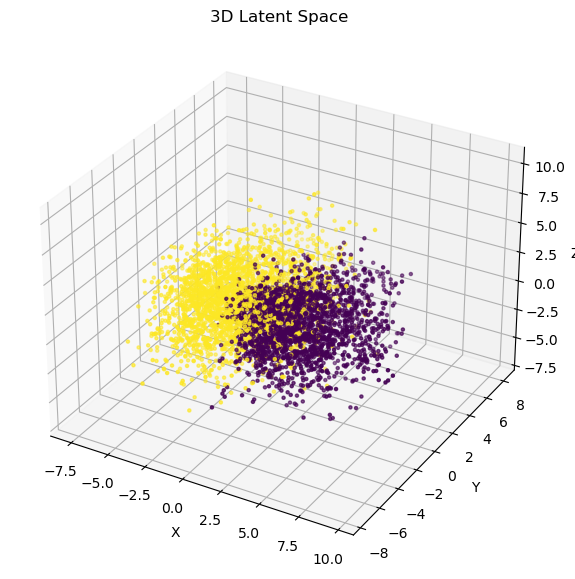

In [35]:
from sklearn.decomposition import PCA

mx_range = 5000

def plot_latent_space_3d(vae, data):
    z_mean, _, _ = vae.encoder.predict(data[:mx_range])
    print(z_mean.shape)    
    n_components = 3  # Number of components to keep
    pca = PCA(n_components=n_components)
    pca.fit(z_mean)
    z_mean_reduced = pca.transform(z_mean)
    fig = plt.figure(figsize = (7, 7))
    ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(z_mean[:, 0], 5*np.ones(len(z_mean)), z_mean[:, 1], c=mixed_label[:mx_range], marker='o')
    ax.scatter(z_mean_reduced[:, 0], z_mean_reduced[:, 1], z_mean_reduced[:, 2], c=mixed_label[:mx_range], marker='.')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Latent Space')
    plt.grid(True, linewidth = 0.3)
    plt.show()

plot_latent_space_3d(vae, mixed)

### Gen.R <br>

Random Generations

993
(1, 128, 128, 1)
reduced-mixed-coord:  [-1.3883959 -1.1131548]
1/1 [==============================] - 0s 18ms/step
(1, 128, 128, 1)


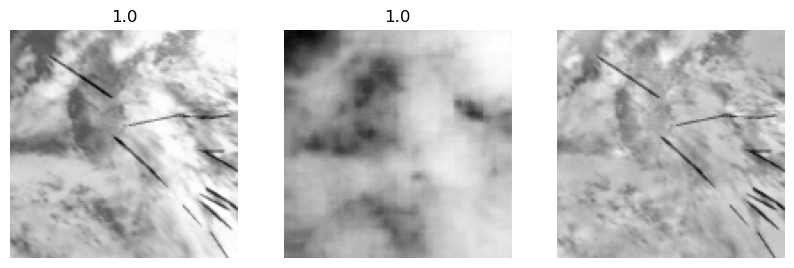

In [40]:
seed = random.randint(0, len(z_mean_reduced) - 1)
# seed = 21
print(seed)

seed_image = np.expand_dims(mixed[seed], axis = 0)
# mask_image = np.expand_dims(human_mask[seed], axis = 0)

print(seed_image.shape)

print("reduced-mixed-coord: ", z_mean_reduced[seed])

z_mean, _, z = vae.encoder.predict(seed_image)
recons_image = vae.decoder.predict(z)

print(recons_image.shape)

fig, axs = plt.subplots(1, 3, figsize = (10, 10))

axs[0].imshow(seed_image[0], cmap='gray')
axs[0].set_title(mixed_label[seed])
axs[0].axis('off')

axs[1].imshow(recons_image[0], cmap='gray')
axs[1].set_title(mixed_label[seed])
axs[1].axis('off')

axs[2].imshow(seed_image[0] - recons_image[0], cmap='gray')
axs[2].axis('off')

plt.show()

#### Latent Arithmetic 

In [41]:
rev_per_index = np.argsort(per_index)
unshuff_mixed = mixed[rev_per_index]

(128, 128, 1) (128, 128, 1)


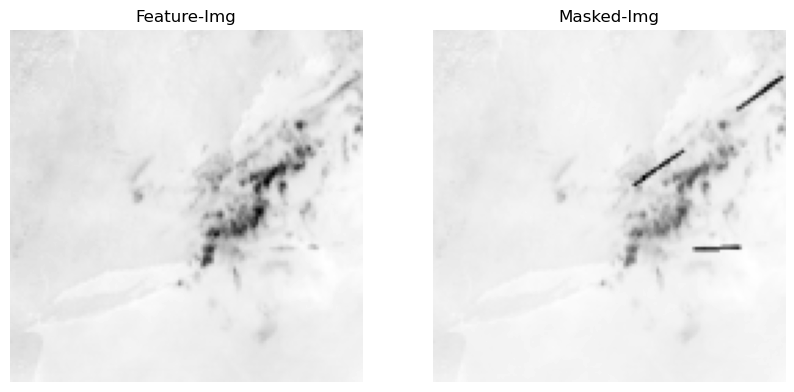

In [42]:
st = 17 ## Initial Point
mid = int(len(mixed) / 2)
feature_img, label_img = unshuff_mixed[st], unshuff_mixed[st + mid]
print(feature_img.shape, label_img.shape)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

axs[0].imshow(feature_img, cmap='gray')
axs[0].set_title("Feature-Img")
axs[0].axis('off')

axs[1].imshow(label_img, cmap='gray')
axs[1].set_title("Masked-Img")
axs[1].axis('off')

plt.show()

In [48]:
z_mean_reduced = z_mean_reduced[rev_per_index]

(1, 128, 128, 1) (1, 128, 128, 1)
reduced-IMG-mixed-coord:  [-0.87717515  0.6259839 ]
reduced-IMG-masked-mixed-coord:  [-5.65586    0.7874633]
- Disparity - Measurement - 
214/214 [==============================] - 2s 10ms/step
(6828, 412)


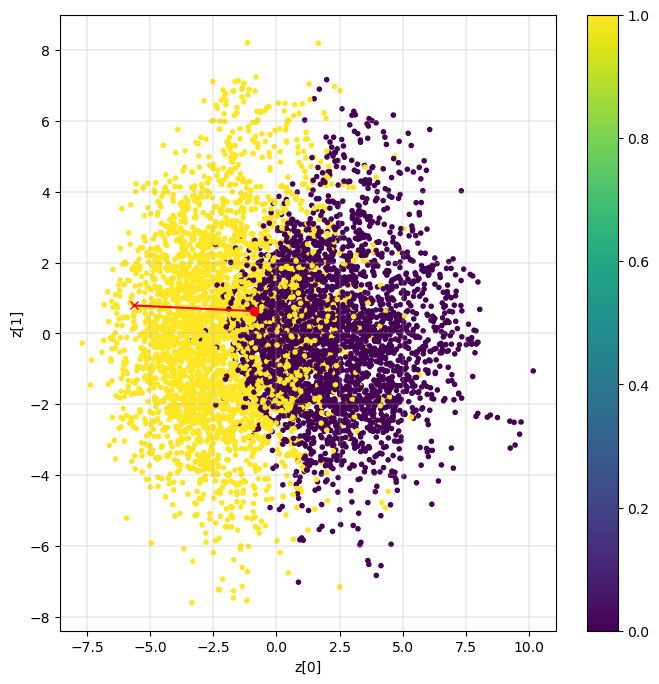

1/1 [==============================] - 0s 19ms/step
(1, 412)
1/1 [==============================] - 0s 19ms/step
(1, 128, 128, 1)


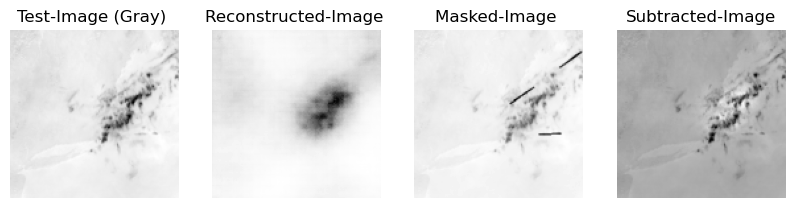

In [49]:
test_img = np.expand_dims(feature_img, axis = 0)
test_img_masked = np.expand_dims(label_img, axis = 0)

print(test_img.shape, test_img_masked.shape)

# z_mean_test, _, _ = vae.encoder.predict(test_img)
# z_mean_masked_test, _, _ = vae.encoder.predict(test_img_masked)

img_coords = z_mean_reduced[st]
mask_coords = z_mean_reduced[st + mid]

print("reduced-IMG-mixed-coord: ", img_coords)
print("reduced-IMG-masked-mixed-coord: ", mask_coords)

print("- Disparity - Measurement - ")

_ = plot_latent_space(vae, mixed)
plt.plot(img_coords[0], img_coords[-1], 'ro')
plt.plot(mask_coords[0], mask_coords[-1], 'rx')
plt.plot([img_coords[0], mask_coords[0]], [img_coords[-1], mask_coords[-1]], '-r')
plt.show()

''' DISPLACEMENT VECTOR ''' ##say for 1 & 2/4 

z_mean_test, _, z_test = vae.encoder.predict(test_img)
z_mean_test_masked, _, z_test_masked = vae.encoder.predict(test_img_masked)

print(z_mean_test.shape)

disp_vec = z_mean_test - z_mean_test_masked
# print('Coord_diff_in_latent: ', disp_vec)

''' This doesn;t mean much in this Problem Space (PS), but for a dual PS if we can segregate the distrib. of have and have-nots, 
they disp. vec is the diff. thing | All distribs. overlap in LS'''

''' THE MASKED REGIONS/CLUSTERS ARE ARRANGING THEMSELVES IN NEGATIVE (x) - DIR  '''
w =  -1.85 # ( 0 < w < 1)
z_new = z_mean_test + w * disp_vec ## ADDITIVE_TRANS: Towards 1s (more distance than 1s and 7s) and 
recons_image = vae.decoder.predict(z_new)

#SUBTRACTIVE_TRANS: Towards 7s (less distance than 1s and 7s) 

# recons_image = pre_arch_vae.decoder.predict(z_mean)

print(recons_image.shape)

fig, axs = plt.subplots(1, 4, figsize = (10, 10))

axs[0].imshow(test_img[0], cmap='gray')
axs[0].set_title("Test-Image (Gray) ")
axs[0].axis('off')

axs[1].imshow(recons_image[0], cmap='gray')
axs[1].set_title("Reconstructed-Image ")
axs[1].axis('off')

axs[2].imshow(test_img_masked[0], cmap='gray')
axs[2].set_title("Masked-Image ")
axs[2].axis('off')

axs[3].imshow(test_img[0] - recons_image[0], cmap='gray')
axs[3].set_title("Subtracted-Image")
axs[3].axis('off')

plt.grid(True, linewidth = 0.3)

plt.show()

#### Latent-Space Optimization | NEED TO SAVE ALL THE DATA AGAIN, IN ONE FLOW <br>


----------------------------

Independent-Execution

In [ ]:
rev_per_index = np.argsort(per_index)
mixed_label_unshuff = mixed_label
unshuff_mixed = mixed
z_mean_unshuff = z_mean ## NOT SHUFFLED as well as z_mean_reduced
mixed_positive_labels_unshuff = mixed_positive_labels

print(z_mean_unshuff.shape, mixed_positive_labels_unshuff.shape, z_mean_unshuff[mixed_positive_labels_unshuff == 1].shape)

Continued Execution

In [54]:
# rev_per_index = np.argsort(per_index)
mixed_label_unshuff = mixed_label[rev_per_index]
unshuff_mixed = mixed[rev_per_index]
z_mean_unshuff = z_mean[rev_per_index] 
# mixed_positive_labels_unshuff = mixed_positive_labels[rev_per_index]

print(z_mean_unshuff.shape, unshuff_mixed.shape)

(6828, 412) (6828, 128, 128, 1)


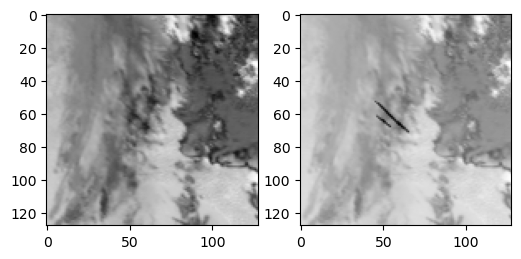

In [57]:
start = 5
pos_len = len(mixed)

fig, axs = plt.subplots(1, 2, figsize = (6, 6))

axs[0].imshow(unshuff_mixed[start], cmap = 'gray')
axs[1].imshow(unshuff_mixed[start + int(pos_len // 2)], cmap = 'gray')

plt.show()

In [59]:
''' FOR EXPT. TESTING | NOT Logically falseProof'''

# pos_len = np.sum(mixed_positive_labels_unshuff)

# unshuff_mixed[mixed_positive_labels_unshuff == 1]
# mixed_label[rev_per_index][mixed_positive_labels_unshuff == 1]

print("No. of Positive-Input : ", pos_len)  #1

position = z_mean_unshuff

position_inp = position[:int(pos_len // 2)]
position_masked = position[int(pos_len // 2):]
# position_masked = z_mean_unshuff[int(len(z_mean) // 2) + 1:][mixed_positive_labels_unshuff[int(len(z_mean) // 2) + 1:] == 1]

print(position_inp.shape, position_masked.shape)

disp_vec_high = position_masked - position_inp 

print(disp_vec_high.shape)

# del position 
# gc.collect()

No. of Positive-Input :  6828
(3414, 412) (3414, 412)
(3414, 412)


In [ ]:
sns.reset_orig()

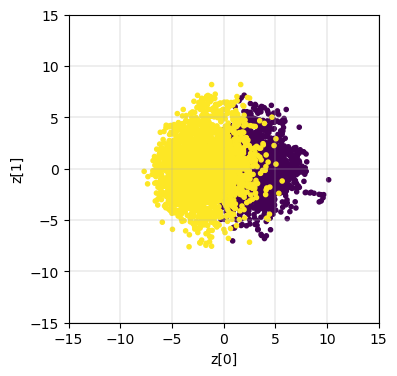

In [60]:
from sklearn.decomposition import PCA

def plot_latent_space(data, label, sampling = False):

    ''' Seperate PCA of positions won't know mutual relative-ness '''
    
    ''' 0/Red/Yellow -> Input | 1/Blue/Black --> Target'''
    
    n_components = 2  # Number of components to keep
    pca = PCA(n_components=n_components)
    fig = plt.figure(figsize = (4,4))
    
    if sampling:
        position = data
        pca.fit(position)
        k1 = pca.transform(position)  
        plt.scatter(k1[:, 0], k1[:, 1], c = label, marker = '.')
    
    else: 
        pca.fit(data)
        k1 = pca.transform(data)  
        plt.scatter(k1[:, 0], k1[:, 1], c = label, marker = '.')
    
#     pca.fit(position_inp)
#     k1 = pca.transform(position_inp)
#     plt.scatter(k1[:, 0], k1[:, 1], marker = '.')
#     del k1
#     gc.collect()
#     pca.fit(position_masked)
#     k2 = pca.transform(position_masked)
#     plt.scatter(k2[:, 0], k2[:, 1], marker = '.')
#     del k2 
#     gc.collect()
#     plt.colorbar()
    
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.grid(True, linewidth = 0.3)
    
        
label = mixed_label_unshuff[:-20]
plot_latent_space(position[:-20], label)
plt.show()

<b> Energy Function </b> --> <br>
1. Can be a <b> Hardcoded Function </b>, that reflects the <b> minimization </b> objective
2. Can be <b> Dense Neural Net </b> (ANN) (Dynamic) parametrised by Weights and Biases

In [61]:
''' HARDCODED ENERGY FUNCTION --> parameterised by latent displacement vector '''

print(disp_vec_high.shape, disp_vec_high.dtype)

print(min(np.ravel(disp_vec_high)), max(np.ravel(disp_vec_high)))
print(min(np.ravel(position_inp)), max(np.ravel(position_inp)))
print(min(np.ravel(position_masked)), max(np.ravel(position_masked)))

(3414, 412) float32
-3.979813 5.2198086
-7.793134 6.3885045
-7.3782444 6.725821


Harmonic Potential (Expt.) | Hard-coded Energy Functions <i> F(d) </i>

(3414,)


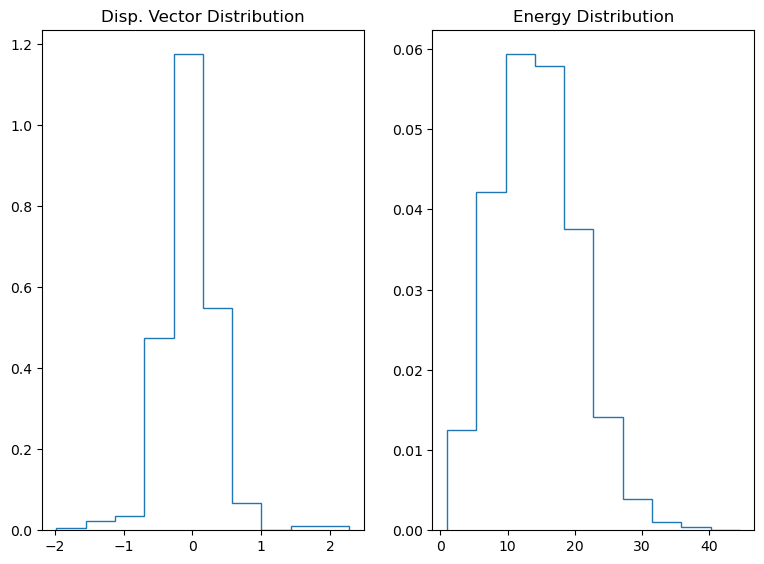

In [62]:
def energy_func(disp_vec, k = 1.0): ## Has to be differentiable | Simple Harmonic Potential
    energy = 0.5 * k * tf.square(disp_vec)
    total_energy = tf.reduce_sum(energy, axis=-1, keepdims = False)
#     total_energy = tf.reshape(total_energy, (-1, 1))
    return total_energy

y = energy_func(disp_vec_high)
print(y.shape)

fig, axs = plt.subplots(1, 2, figsize = (8, 6))

axs[1].hist(y, histtype = 'step', density = True)
axs[1].set_title("Energy Distribution")

axs[0].hist(disp_vec_high[3], histtype = 'step', density = True)
axs[0].set_title("Disp. Vector Distribution")

plt.tight_layout(pad = 2)
plt.show()

In [63]:
del position_inp, position_masked
gc.collect()

19245

#### DYnamiC Energy Function | Dense Neural Net --> parametrised by model {W, b}, making it dynamic 

In [64]:
import time

latent_dim = z_mean.shape[-1]
batch_size = 16
step_size = 10
std_dev = 0.005
steps = 10
GRADIENT_CLIP = 0.03
value_clip = 3.5 #1
latent_clip = 7 #1
buffer_size = 512
ALPHA = 0.1
CW = 1.5

print('LATENT-DIM: ', latent_dim)

LATENT-DIM:  412


In [65]:
inp = tf.keras.layers.Input(shape = (latent_dim, ))
x = tf.keras.layers.Dense(1024, activation = 'relu')(inp)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(1, activation = 'linear')(x)

model = tf.keras.models.Model(inputs = inp, outputs = out, name = 'DNN_Energy_Function')
model.summary()

Model: "DNN_Energy_Function"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 412)]             0         
                                                                 
 dense (Dense)               (None, 1024)              422912    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                               

#### Min-Max Scaling

In [66]:
def min_max_scaling(data):
    min_val = min(np.ravel(data))
    max_val = max(np.ravel(data))
    scaled_data = [(2 * (x - min_val) / (max_val - min_val)) - 1 for x in data]
    return np.array(scaled_data), min_val, max_val

def descale_min_max(normalized_data, original_min, original_max):
    descaled_data = [((x + 1) * (original_max - original_min) / 2) + original_min for x in normalized_data]
    return np.array(descaled_data)

In [68]:
position_inp = z_mean_unshuff[: int(pos_len/2)]
position_target = z_mean_unshuff[int(pos_len/2):]
disp_vec_high = position_target - position_inp 

trunc_len = int(pos_len/2 - (pos_len/2 % 16))

position_inp = position_inp[:trunc_len]
position_target = position_target[:trunc_len]
disp_vec_high = disp_vec_high[:trunc_len]

'''SCALING'''

# ft = time.time()

# position_inp, min_val_inp, max_val_inp = min_max_scaling(position_inp)
# position_target, min_val_tg, max_val_tg = min_max_scaling(position_target)
# disp_vec_high, min_val_d, max_val_d = min_max_scaling(disp_vec_high)

# lt = time.time()

# print("time-taken-to-scale: ", (lt - ft)/60)
# print("Min-Max: ", min_val_d, max_val_d)

print(min(np.ravel(disp_vec_high)), max(np.ravel(disp_vec_high)))
print(min(np.ravel(position_inp)), max(np.ravel(position_inp)))
print(min(np.ravel(position_target)), max(np.ravel(position_target)))

print(position_inp.shape, position_inp.dtype, position_target.shape, position_inp.dtype, disp_vec_high.shape, disp_vec_high.dtype)

'''WRONG --> you have elimminated targets ONLY'''
label = mixed_label_unshuff[:2*trunc_len]

-3.979813 5.2198086
-7.793134 6.3885045
-7.3782444 6.725821
(3408, 412) float32 (3408, 412) float32 (3408, 412) float32


In [69]:
def langevin_sampling(model, data, steps, step_size, std_dev, return_per_step=False, training = False, 
                      _gen = False, seed = 0):
    
    ### Position needs to update
    if training:
        position, approx_disp = data
    else:
        position, position_target, approx_disp = data
        
#     inp, position = inps
    disp_per_step = []
    for i in range(steps):
        approx_disp += tf.random.normal(approx_disp.shape, mean=0, stddev=std_dev)
        approx_disp = tf.clip_by_value(approx_disp, - value_clip, value_clip)     
        with tf.GradientTape() as tape:
            tape.watch(approx_disp)
            position += approx_disp
            out_score = model(position)
        grads = tape.gradient(out_score, approx_disp)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        approx_disp -= step_size * grads ## Minimizing energy function
        approx_disp = tf.clip_by_value(approx_disp, - value_clip, value_clip)
       
        if training == False: 
            if _gen:
                if i == (steps - 1):
                    temp_pos = np.concatenate([position.numpy(), position_target], axis = 0)
                    gen_label = np.array([label[seed], label[seed + int(trunc_len / 2)]])
#                     plot_latent_space(temp_pos, gen_label, sampling = True)
            else:
                if i % 5 == 0:
                    temp_pos = np.concatenate([position.numpy(), position_target], axis = 0)
                    ''' PLOT = OFF '''
#                     plot_latent_space(temp_pos, label, sampling = True)
                    del temp_pos
                    gc.collect()
        
        if return_per_step:
            disp_per_step.append(approx_disp)
    if return_per_step:
        return tf.stack(disp_per_step, axis=0)
    else:
        return approx_disp
    
''' NOT parameterising on distance between the points, just 2D coordinate-difference '''
    
### WORKS: Minimizes the harmonic potential at (|x2 - x1| ~= 0) which has min P.E and Max K.E
# disp_vec_tf = tf.convert_to_tensor(disp_vec_high, dtype=tf.float32)
randn_disp = np.random.uniform(low = -value_clip, high = value_clip, size = disp_vec_high.shape)
disp_sample = langevin_sampling(energy_func, [position_inp, position_target, randn_disp], 
                                steps, step_size, std_dev)
print(disp_sample.shape)

(3408, 412)


In [70]:
class Buffer:
    def __init__(self, mode):
        super().__init__()
        self.model = model
        ## to bring it to range of [-1, 1] we include extra operation 
        self.examples = [(tf.random.uniform(shape=(1, latent_dim)) * 6) - 3 for _ in range(batch_size)]

    def sample_new_exmps(self, position_inp, steps, step_size, std_dev):
        ### expectation of n_new is going to be ~ 5% of batch_size
        n_new = np.random.binomial(batch_size, 0.05)
        rand_disp = (
            tf.random.uniform((n_new, latent_dim)) * 6 - 3
        )
        prev_disp = tf.concat(
            ## returns a k-size list with replacement (meaning repeatation and ommision of elements will take place)
            random.choices(self.examples, k = batch_size - n_new), axis=0
        )
        approx_disp = tf.concat([rand_disp, prev_disp], axis=0)
        approx_disp = langevin_sampling(self.model, [position_inp, approx_disp], steps=steps, step_size=step_size, 
                                        std_dev=std_dev, training = True)
        self.examples = tf.split(approx_disp, batch_size, axis=0) + self.examples
        self.examples = self.examples[:buffer_size]
        return approx_disp

In [71]:
class EBM(tf.keras.models.Model):
    def __init__(self):
        super().__init__() ## calls constructor of the parent class
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.CW = CW
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.reg_loss_metric = tf.keras.metrics.Mean(name="reg")
        self.cdiv_loss_metric = tf.keras.metrics.Mean(name="cdiv")
        self.target_score_metric = tf.keras.metrics.Mean(name="target")
        self.approx_score_metric = tf.keras.metrics.Mean(name="approx")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.target_score_metric,
            self.approx_score_metric,
        ]

    def train_step(self, inputs):
        
        ini_pos, target_pos = inputs[0]
#         target_pos += tf.random.normal(
#             shape=tf.shape(target_pos), mean=0, stddev=std_dev
#         )
        target_pos = tf.clip_by_value(target_pos, -latent_clip, latent_clip)
        approx_disp = self.buffer.sample_new_exmps(position_inp = ini_pos, steps=steps, step_size=step_size, std_dev = std_dev)
        ini_pos += approx_disp
        inp = tf.concat([target_pos, ini_pos], axis=0)
        with tf.GradientTape() as training_tape:
            ''' Here you are entring initial_position and target_position NOT apprx. disp vector '''
            target_score, approx_score = tf.split(self.model(inp), 2, axis=0)
            ### Difference between mean positions of fake (un) and real img
            ### from the intial cluster position add the disp. vec to reach the target cluster position
            ### MLE ---> Distrib. Approx.
            cdiv_loss = self.CW * abs(tf.reduce_mean(approx_score, axis=0) - tf.reduce_mean(target_score, axis=0))
#             cdiv_loss = abs(tf.reduce_mean(tf.square(approx_score - target_score)))
            reg_loss = self.alpha * tf.reduce_mean(target_score**2 + approx_score**2, axis=0)
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.target_score_metric.update_state(tf.reduce_mean(target_score, axis=0))
        self.approx_score_metric.update_state(tf.reduce_mean(approx_score, axis=0))
        return {m.name: m.result() for m in self.metrics}

In [72]:
ebm = EBM() ## default name of a model called in parent constructor is 'model'

ebm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), run_eagerly=True
)

epochs = 50

position = np.concatenate([position_inp, position_target], axis = 0)
#     tf.convert_to_tensor(position, dtype = 'float32'),

es = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

ebm.fit(
    x = (position_inp, position_target),
    shuffle=True,
    batch_size = batch_size,
    epochs=epochs,
#     callbacks = [es]
)

Epoch 1/50
213/213 [==============================] - 45s 202ms/step - loss: 0.2432 - reg: 0.0642 - cdiv: 0.1790 - target: 0.0900 - approx: 0.0180
Epoch 2/50
213/213 [==============================] - 43s 202ms/step - loss: 0.0335 - reg: 9.4284e-04 - cdiv: 0.0326 - target: -0.0080 - approx: -0.0131
Epoch 3/50
213/213 [==============================] - 43s 201ms/step - loss: 0.0180 - reg: 3.1791e-04 - cdiv: 0.0177 - target: -0.0014 - approx: -1.4267e-04
Epoch 4/50
213/213 [==============================] - 43s 200ms/step - loss: 0.0121 - reg: 1.3417e-04 - cdiv: 0.0119 - target: 2.3728e-04 - approx: -7.2128e-04
Epoch 5/50
213/213 [==============================] - 42s 199ms/step - loss: 0.0047 - reg: 3.2657e-05 - cdiv: 0.0047 - target: -1.0573e-04 - approx: -6.7148e-05
Epoch 6/50
213/213 [==============================] - 43s 200ms/step - loss: 0.0019 - reg: 4.8867e-06 - cdiv: 0.0019 - target: 5.3242e-04 - approx: 5.6609e-04
Epoch 7/50
213/213 [==============================] - 42s 198ms

KeyboardInterrupt: 

In [73]:
import time

seed = 350
steps = 100

randn_disp = np.random.uniform(low = -3.5, high = 3.5, size = disp_vec_high.shape)
desired_inputs = [position_inp[:seed], position_target[:seed], randn_disp[:seed]]

ft = time.time()

gen_disp = langevin_sampling(
    ebm.model,
    desired_inputs,
    steps = steps,
    step_size = step_size,
    std_dev = std_dev,
    _gen = True,
    seed = seed
)

lt = time.time()

print("Time_Taken: ", (lt - ft)/60)

# ------------------------------------------------------------------------------ #

z_test, _, _ = vae.encoder.predict(test_img)
z_test = z_test.reshape(1, -1)

z_test_masked,_ ,_ = vae.encoder.predict(test_img_masked)
z_test_masked = z_test_masked.reshape(1, -1)

randn_disp = np.random.uniform(low = -3.5, high = 3.5, size = z_test.shape)
desired_inputs = [z_test, z_test_masked, randn_disp]

ft = time.time()

gen_disp_test = langevin_sampling(
    ebm.model,
    desired_inputs,
    steps = steps,
    step_size = step_size,
    std_dev = std_dev,
    _gen = True,
    seed = seed
)

lt = time.time()

print("Time_Taken: ", (lt - ft)/60)


# gen_disp = descale_min_max(gen_disp, min_val_d, max_val_d)



# gen_disp_so = langevin_sampling(
#     ebm.model,
#     desired_inputs,
#     steps=71,
#     step_size = step_size,
#     std_dev = std_dev,
#     _gen = True,
#     seed = seed
# )

print(gen_disp.shape, gen_disp_test.shape)
# print(min(np.ravel(gen_disp)), max(np.ravel(gen_disp)))
# print(gen_disp_so)

Time_Taken:  0.028011786937713622
1/1 [==============================] - 0s 25ms/step
Time_Taken:  0.025626643498738607
(350, 412) (1, 412)


In [ ]:
''' IF MIN-MAX SCALED  '''

position_inp = descale_min_max(position_inp, min_val_inp, max_val_inp)
position_target = descale_min_max(position_target, min_val_tg, max_val_tg)
disp_vec_high = descale_min_max(disp_vec_high, min_val_d, max_val_d)

[0.5657232  0.02745218] [ 0.3657232  -0.17254782]


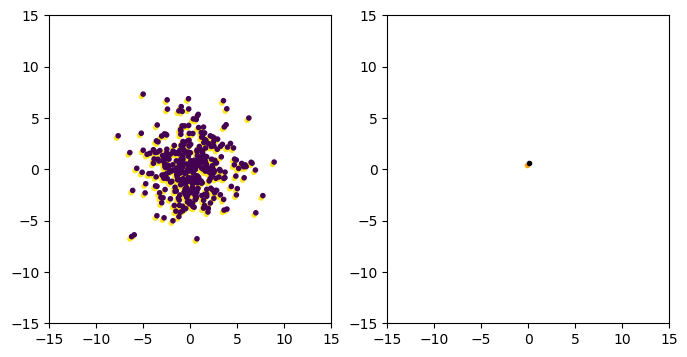

In [74]:
def plot_OG(data, pos_target, label, disp, sampling = False):

    ''' Seperate PCA of positions won't know mutual relative-ness '''
    
    n_components = 2  # Number of components to keep
    pca = PCA(n_components=n_components)
    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    
    pos_inp = data + disp
    
    print(pos_inp[0][:2], position_target[0][:2])
    
    pos = np.concatenate([pos_inp, pos_target], axis = 0)
    pca.fit(pos)
    k1 = pca.transform(pos)  
    axs[0].scatter(k1[:, 0], k1[:, 1], c = 1 - label, marker = '.') ## why?
    axs[0].set_xlim(-15, 15)
    axs[0].set_ylim(-15, 15)

    st = 0
    axs[1].scatter(k1[st, 0], k1[st, 1], c = 'orange', marker = '.')  #0
    axs[1].scatter(k1[st + int(len(k1) / 2), 0], k1[st + int(len(k1) / 2), 1], c = 'black', marker = '.') #1
    axs[1].set_xlim(-15, 15)
    axs[1].set_ylim(-15, 15)
        

gen_label = np.concatenate([np.zeros(seed), np.ones(seed)])
plot_OG(position_inp[:seed], position_target[:seed], gen_label, disp_vec_high[:seed] + 0.2)

Need some <b>  Attention </b> over here

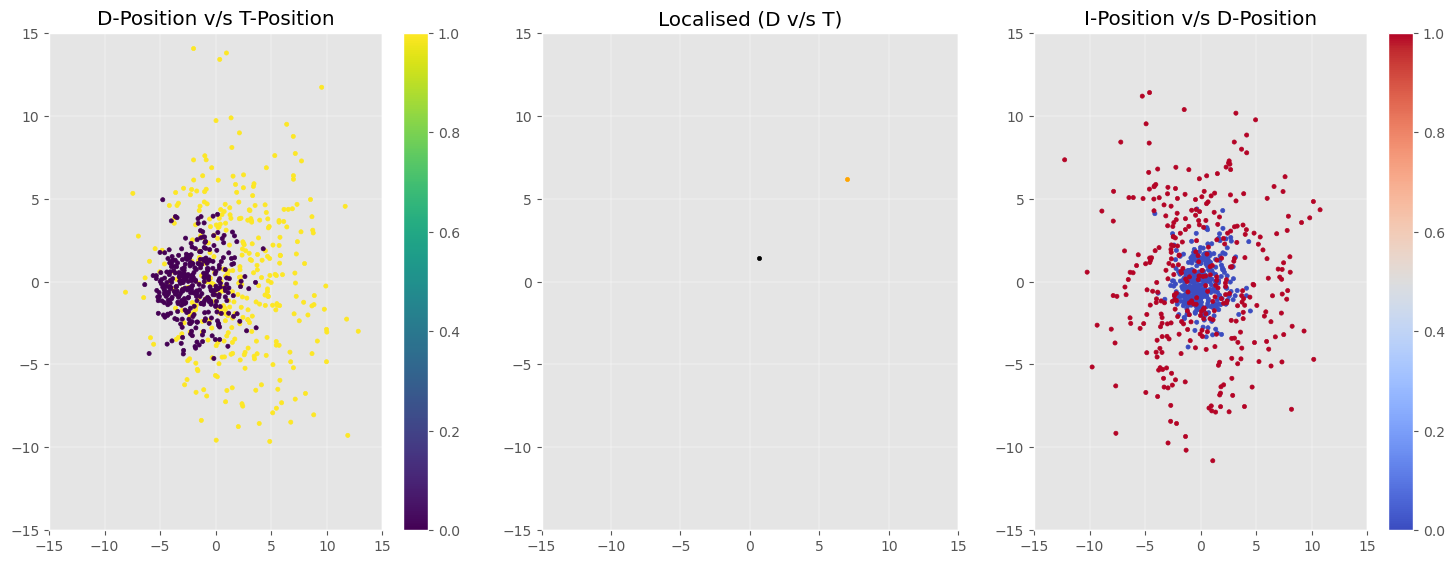

In [75]:
def plot_gen_disp(new_pos, pos_ini, pos_target, label, sampling = False):

    ''' Seperate PCA of positions won't know mutual relative-ness '''
    
    n_components = 2  # Number of components to keep
    pca_1 = PCA(n_components=n_components)
    pca_2 = PCA(n_components=n_components)
    
    plt.style.use('ggplot')
    
    fig, axs = plt.subplots(1, 3, figsize = (15,6))
    
    pos = np.concatenate([new_pos, pos_target], axis = 0)
    pos_disp = np.concatenate([pos_ini, new_pos], axis = 0)
    
    pca_1.fit(pos)
    pca_2.fit(pos_disp)
    
    k1 = pca_1.transform(pos)
    k2 = pca_2.transform(pos_disp)
    
    im1 = axs[0].scatter(k1[:, 0], k1[:, 1], c = 1 - label, marker = '.') ## why?
    axs[0].set_xlim(-15, 15)
    axs[0].set_ylim(-15, 15)
    axs[0].grid(True, linewidth = 0.3)
    axs[0].set_title('D-Position v/s T-Position',  color = 'black')
    fig.colorbar(im1, ax=axs[0])
    
    st = 2
    axs[1].scatter(k1[st, 0], k1[st, 1], c = 'orange', marker = '.')  #0
    axs[1].scatter(k1[st + int(len(k1) / 2), 0], k1[st + int(len(k1) / 2), 1], c = 'black', marker = '.') #1
    axs[1].set_xlim(-15, 15)
    axs[1].set_ylim(-15, 15)
    axs[1].grid(True, linewidth = 0.3)
    axs[1].set_title('Localised (D v/s T)',  color = 'black')
    
    im2 = axs[2].scatter(k2[:, 0], k2[:, 1], c = np.concatenate([np.zeros(seed), np.ones(seed)]), marker = '.', cmap = 'coolwarm') ## why?
    axs[2].set_xlim(-15, 15)
    axs[2].set_ylim(-15, 15)
    axs[2].grid(True, linewidth = 0.3)
    fig.colorbar(im2, ax=axs[2])
    axs[2].set_title('I-Position v/s D-Position', color = 'black')
        

new_pos_inp = position_inp[:seed] + gen_disp
gen_label = np.concatenate([np.zeros(seed), np.ones(seed)])
plot_gen_disp(new_pos_inp, position_inp[:seed], position_target[:seed], gen_label)

plt.tight_layout(pad = 2)
# plt.legend()
plt.show()

In [76]:
print("Mean-Percentage-Error (Generated-latent-displacement): ", np.mean(abs((gen_disp - disp_vec_high[:seed])/disp_vec_high[:seed])), '%')

Mean-Percentage-Error (Generated-latent-displacement):  183.47331 %


#### Directed DECODE-ing

(1, 412)
1/1 [==============================] - 0s 17ms/step
(1, 128, 128, 1)


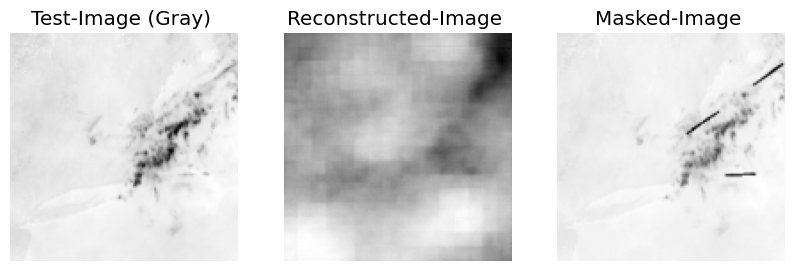

(1, 412)
1/1 [==============================] - 0s 16ms/step
(1, 128, 128, 1)


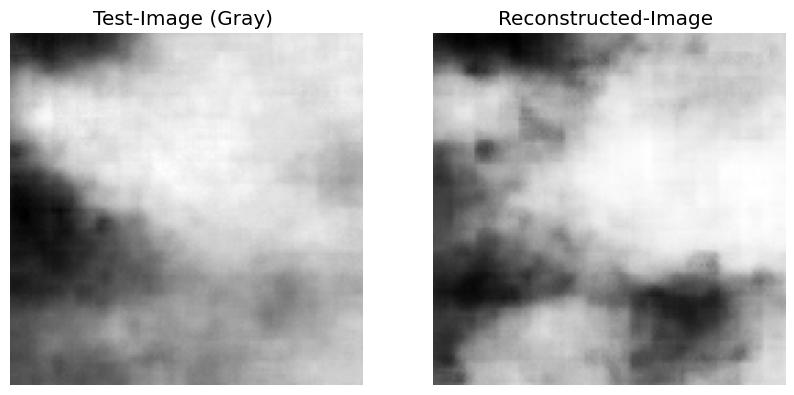

In [77]:

''' DISPLACEMENT VECTOR ''' ##say for 1 & 2/4 

''' This doesn't mean much in this Problem Space (PS), but for a dual PS if we can segregate the distrib. of have and have-nots, 
they disp. vec is the diff. thing | All distribs. overlap in LS'''

''' THE MASKED REGIONS/CLUSTERS ARE ARRANGING THEMSELVES IN NEGATIVE (x) - DIR  '''

print(z_test.shape)

w =  - 0.5

new_pos_inp = z_mean_test + (w * gen_disp_test)  
recons_image = vae.decoder.predict(new_pos_inp)

print(recons_image.shape)

fig, axs = plt.subplots(1, 3, figsize = (10, 10))

axs[0].imshow(test_img[0], cmap='gray')
axs[0].set_title("Test-Image (Gray) ")
axs[0].axis('off')

axs[1].imshow(recons_image[0], cmap='gray')
axs[1].set_title("Reconstructed-Image ")
axs[1].axis('off')

axs[2].imshow(test_img_masked[0], cmap='gray')
axs[2].set_title("Masked-Image ")
axs[2].axis('off')

plt.show()

# ------------------------------------------------------------------ #

w = 1.0 # ( 0 < w < 1)

select_idx = random.randint(0, len(gen_disp) - 1)

z_mean_inp = position_inp[select_idx].reshape(1, -1)
print(z_mean_inp.shape)

new_pos_inp = z_mean_inp + w * gen_disp[select_idx]

input_image = vae.decoder.predict(z_mean_inp)
recons_image = vae.decoder.predict(new_pos_inp)

print(recons_image.shape)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

axs[0].imshow(input_image[0], cmap='gray')
axs[0].set_title("Test-Image (Gray) ")
axs[0].axis('off')

axs[1].imshow(recons_image[0], cmap='gray')
axs[1].set_title("Reconstructed-Image ")
axs[1].axis('off')

# axs[2].imshow(test_img_masked[0], cmap='gray')
# axs[2].set_title("Masked-Image ")
# axs[2].axis('off')

plt.show()